# WPM 3D with storing intermediate data

3D drawings are very nice, but sometimes we have not enough memory to store data. In this case we can use the following functions at Scalar_fields_XY scheme: WPM and BPM.

It is quite easy to execute them at vacuum, as only a XY initial field is required. However it is also possible to use a 3d refractive index structure. In order to not storing it, a function with the XYZ definition is required. However, the data are only extracted for each z position, and then no problems with storage are produced.

In my compute I have got the following results:
- 128 x 128 x 128 = 600 ms
- 256 x 256 x 256 = 5 seconds
- 512 x 512 x 512 = 44 seconds (I could not resolve it in XYZ).
- 1024 x 1024 x 1024 = 7 minutes (I could not resolve it in XYZ).



## Modules

In [23]:
from diffractio import np, plt, um, degrees

from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.scalar_masks_XYZ import Scalar_mask_XYZ

In [24]:
num_z = 150

x = np.linspace(-50 * um, 50 * um, 256)
y = np.linspace(-50 * um, 50 * um, 256)
z = np.linspace(0, 101 * um, num_z)
z_obs = z[-1]
wavelength = 5 * um

In [25]:
t0 = Scalar_mask_XY(x, y, wavelength)
t0.circle(r0=(0 * um, 0 * um), radius=45 * um, angle=0)

u0 = Scalar_source_XY(x, y, wavelength)
u0.plane_wave()

u_iter = u0 * t0

In [26]:
def fn(x, y, z, wavelegth):
    u = Scalar_mask_XYZ(x, y, z, wavelength)
    u.sphere(
        r0=(0 * um, 0 * um, 50 * um),
        radius=35 * um,
        refractive_index=1.5,
        rotation=None,
    )
    index = u.n
    del u
    return np.squeeze(index)

In [27]:
# Example of structure at a given k-position in z distance
refractive_index = fn(
    x,
    y,
    np.array(
        [
            44,
        ]
    ),
    wavelength,
)

In [28]:
zs = np.linspace(z[0], z[-1], num_z)

num_sampling = (len(x), len(y), len(z))

ROI_x = np.linspace(-50 * um, 50 * um, 50)
ROI_y = np.linspace(-50 * um, 50 * um, 51)
ROI_z = np.linspace(0, 100 * um, 52)

ROI = (ROI_x, ROI_y, ROI_z)

In [29]:
%%time
u_iter2, u_out_gv2, u_out_roi2, u_axis_x, u_axis_z, u_max, z_max = u_iter.WPM(fn, zs =zs, has_edges=np.zeros_like(z), num_sampling=num_sampling, ROI = ROI, matrix=False, verbose=True)

Time = 1.12 s, time/loop = 7.449 ms
CPU times: user 1.23 s, sys: 2.01 s, total: 3.24 s
Wall time: 3.24 s


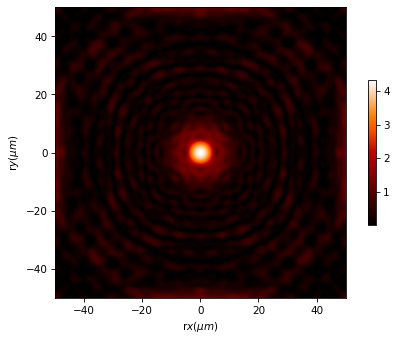

In [30]:
u_iter2.draw(logarithm=1e0, has_colorbar="vertical")

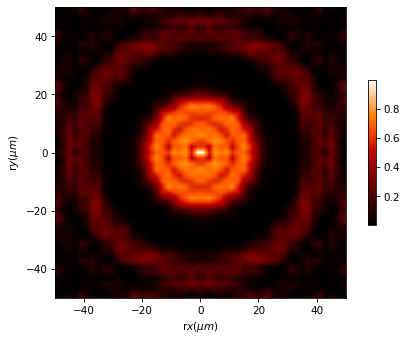

In [31]:
u_out_roi2.draw_XY(z0=60, logarithm=1e0, has_colorbar="vertical")

### Maximum intensity position

92.18791946308725


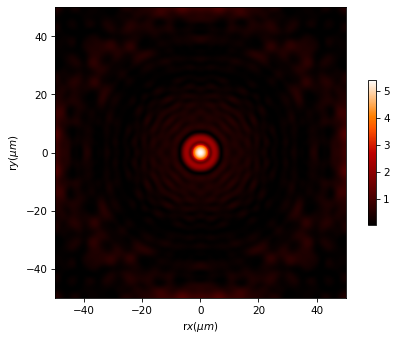

In [32]:
u_max.draw(logarithm=1e0, has_colorbar="vertical")
print(z_max)

## Comparison with 3D
We perform the same experiment, but storing data. Finally, a comparison between both procedures is performed.

In [33]:
u_3d = Scalar_mask_XYZ(x, y, z, wavelength)
u_3d.n = fn(x, y, z, wavelength)

In [34]:
u_3d.incident_field(u0=u0 * t0)

In [35]:
%%time
u_3d.clear_field()
u_3d.WPM(verbose=True, has_edges=False)


Time = 1.10 s, time/loop = 7.301 ms
CPU times: user 1.1 s, sys: 34.4 ms, total: 1.13 s
Wall time: 1.13 s


<Figure size 480x360 with 0 Axes>

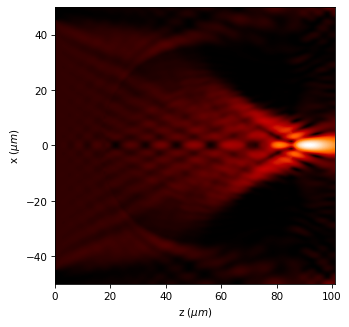

In [36]:
u_3d.draw_XZ(y0=0, logarithm=1e0)
plt.axis("scaled")

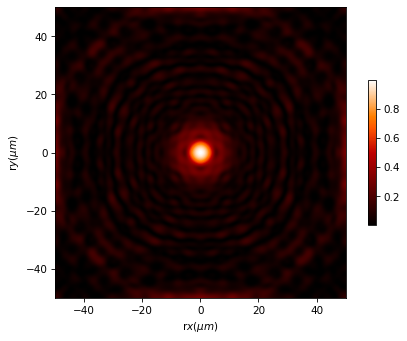

In [37]:
u_3d.draw_XY(z0=100 * um, logarithm=1e0, has_colorbar="vertical")

## Differences between both algorithms

Differences = 0.00 %


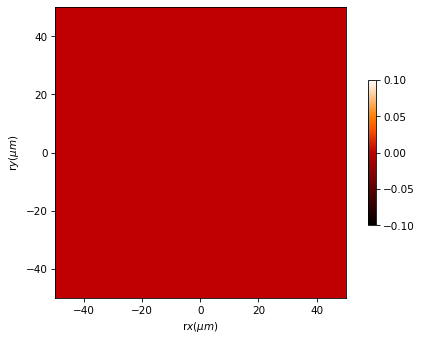

In [38]:
I_3d_final = np.abs(u_3d.u[:, :, -1]) ** 2
I_iter = np.abs(u_iter2.u) ** 2

u_diffs = Scalar_mask_XY(x, y, wavelength)
u_diffs.u = (I_iter - I_3d_final) / I_iter.max()

u_diffs.draw(has_colorbar="vertical", logarithm=1e3)
print(
    "Differences = {:2.2f} %".format(
        (100 * np.abs((I_iter - I_3d_final) / I_iter.max()).mean())
    )
)